In this notebook we will build 4 models to do the classification task of predicting Pnuemonia by using 5216 X-ray images to train each of our model. The descrption of models are as below:
1. Simple Logistic Regression model with training data as flattened grayscale images.
2. Simple LeNet-5 architechture CNN with training data as grayscale images.
3. Modified CNN with data augmentaion encorporated to add diversity and noise in data which uses 3 channel images.
4. Pre trained VGG-16 model along with FC layer trained on 3 channel images.
<br><br> We evaluate each of the 4 models on the test dataset which contains 624 X-ray images.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression


from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

In [ ]:
dataset_name = '/kaggle/input/chest-xray-pneumonia'

# assuming data is contained in a train and a validation set
train_data_dir = dataset_name + '/chest_xray' + '/train/'
test_data_dir = dataset_name + '/chest_xray' + '/test/'
val_data_dir = dataset_name + '/chest_xray' + '/val/'

# Set up some parameters for data loading
sample_rate = 1.0

# desired dimensions of our images.
img_width, img_height = 162, 128

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

input_shape_gray = (img_width, img_height, 1)

Importing training data and transforming into required input shape (162*128). We import data in both grayscale and rgb channels.

In [ ]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_train = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
X_train_gray = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
y_train= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
    X_data_part_gray = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        # Loading images in color
        image = cv2.imread(image_file, cv2.IMREAD_COLOR) 
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # Loading images in grayscale
        image_gray = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE) #reading images as grayscale
        image_gray = cv2.resize(image_gray, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        X_data_part_gray[i] = image_gray
        X_data_part_gray[i] = X_data_part_gray[i]/255
        
        # Add label to label array
        y_train = np.append(y_train, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_train = np.append(X_train, X_data_part, axis=0)
    X_train_gray = np.append(X_train_gray, X_data_part_gray, axis=0)
    
print("Data shape color: {}".format(X_train.shape))
print("Data shape gray: {}".format(X_train_gray.shape))

Repeat the same process for test and validation data while importing.

In [ ]:
test_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_test = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
X_test_gray = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
y_test= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(test_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = test_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
    X_data_part_gray = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        # Loading images in color
        image = cv2.imread(image_file, cv2.IMREAD_COLOR) 
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # Loading images in grayscale
        image_gray = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE) #reading images as grayscale
        image_gray = cv2.resize(image_gray, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        X_data_part_gray[i] = image_gray
        X_data_part_gray[i] = X_data_part_gray[i]/255
        
        # Add label to label array
        y_test = np.append(y_test, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_test = np.append(X_test, X_data_part, axis=0)
    X_test_gray = np.append(X_test_gray, X_data_part_gray, axis=0)
    
print("Data shape color: {}".format(X_test.shape))
print("Data shape gray: {}".format(X_test_gray.shape))

Importing validation data and applying transformation to resize.

In [ ]:
val_class_folders = [i for i in os.listdir(val_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_val = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
X_val_gray = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
y_val= np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(val_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = val_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
    X_data_part_gray = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        # Loading images in color
        image = cv2.imread(image_file, cv2.IMREAD_COLOR) 
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # Loading images in grayscale
        image_gray = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE) #reading images as grayscale
        image_gray = cv2.resize(image_gray, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        X_data_part_gray[i] = image_gray
        X_data_part_gray[i] = X_data_part_gray[i]/255
        
        # Add label to label array
        y_val = np.append(y_val, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_val = np.append(X_val, X_data_part, axis=0)
    X_val_gray = np.append(X_val_gray, X_data_part_gray, axis=0)
    
print("Data shape color: {}".format(X_val.shape))
print("Data shape gray: {}".format(X_val_gray.shape))

Displaying some of the trasformed images from training data.

In [ ]:
pltsize=2
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray((X_train[i_rand]*255).astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_train[i_rand]))

Also,we can output and compare our grayscale images data.

In [ ]:
pltsize=2
row_images = 3
col_images = 3
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_gray.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X_train_gray[i_rand]*255).astype('int').reshape(162,128), cmap='gray', vmin=0, vmax=255)
    plt.title((str(i_rand) + " " + str(y_train[i_rand])))

1. Creating and training a <b>logistic regression model</b> on our training data and testing immedite performance on validation data.
We will be using grayscale images for this.<br> Logistic regression model needs input as 2D array for training feature so we need to flatten our X_train_gray and X_val_gray for training.

In [ ]:
#initializing arrays
X_train_lr = np.ndarray((X_train_gray.shape[0],X_train_gray[0].flatten().shape[0]), dtype=np.float)
X_val_lr = np.ndarray((X_val_gray.shape[0],X_val_gray[0].flatten().shape[0]), dtype=np.float)

for i,j in zip(range(X_train.shape[0]),range(X_val.shape[0])):
    X_train_lr[i] = X_train_gray[i].flatten()
    X_val_lr[j] = X_val_gray[j].flatten()    
    
print('X_train_lr shape = ',X_train_lr.shape)
print('X_val_lr shape = ',X_val_lr.shape)

In [ ]:
lr_model = LogisticRegression().fit(X_train_lr,y_train)
y_pred = lr_model.predict(X_train_lr)
print(metrics.classification_report(y_train, y_pred))

Testing our model on validation data.

In [ ]:
y_pred = lr_model.predict(X_val_lr)
print(metrics.classification_report(y_val, y_pred))

We get 50% acuracy with our flattened images from a basic Logistic regression model. But we lose the important information a 2D image can provide with the pixel structures. 
2. Next, we  create and train convolutional neural network model to recognise pneumonia in these images.

In [ ]:
#Reshaping training and validation data to add channel dimention for CNN
X_train_cnn = X_train_gray.reshape(X_train_gray.shape[0], img_width, img_height, 1)
X_train_cnn.shape

In [ ]:
X_val_cnn = X_val_gray.reshape(X_val_gray.shape[0], img_width, img_height, 1)
X_val_cnn.shape

In [ ]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_val_num = y_train_encoder.fit_transform(y_val)
y_val_wide = keras.utils.to_categorical(y_val_num, num_classes)

In [ ]:
#trying out classic LeNet-5 model
#Instantiate an empty model
model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=(162, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(120, (5, 5)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


In [ ]:
batch_size = 256
epochs = 20

history = model.fit(X_train_cnn, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_cnn, y_val_wide))

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
# Make a set of predictions for the validation data
pred = model.predict_classes(X_val_cnn)

# Print performance details
print(metrics.classification_report(y_val_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_val_num, pred))

3. Next, we will use data augmentation techniques to increase diversity in the dataset and then train a CNN on that data.

In [ ]:
pltsize=2
row_images = 3
col_images = 3

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)

datagen.fit(X_train)

for idx in range(0, 4):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray((X_train[idx]*255).astype(np.uint8)))
    plt.title("Original")

    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((rand_trans*255).astype(np.uint8)))
        plt.title(i)

    plt.show() 

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), input_shape=input_shape))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(32, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Flatten())
model_aug.add(Dense(256, activation = 'relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(2, activation = 'softmax'))

model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_aug.summary()

In [ ]:
batch_size = 256
epochs = 20

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook01.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)

datagen_train.fit(X_train)
        
history_aug = model_aug.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train) / batch_size,
          validation_data=(X_val, y_val_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model_aug.load_weights(best_weights_filepath)

In [ ]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
# Make a set of predictions for the validation data
pred = model_aug.predict_classes(X_val)

# Print performance details
print(metrics.classification_report(y_val_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_val_num, pred))

4. For the last model we will use VGG-16 pre-trained model.

In [ ]:
# build the VGG16 network
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Now, we append our old trained model with VGG-16. We will use the exact same fully connected layers from our model_aug and add to VGG-16.

In [ ]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(2, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = keras.Model(vgg16_model.input, final_layer)

# moving over weights from a pre-trained smaller model specifically for our problem might help rather than random initialisation.
top_weights_filepath = './best_weights_notebook22.hdf5'
old_model = keras.models.load_model(top_weights_filepath)
full_model.layers[-1].set_weights(old_model.layers[-1].get_weights())

# set the first 17 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in full_model.layers[:17]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
full_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

full_model.summary()

In [ ]:
batch_size = 256
epochs = 20

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook23.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data=(X_val, y_val_wide),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
full_model.load_weights(best_weights_filepath)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [ ]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_val),axis=1)

# Print performance details
print(metrics.classification_report(y_val_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_val_num, pred))

### Evaluation

We are going to test our 4 models : lr_model, model, model_aug and full_model on test data and then compare the prediction results for each of these models.

In [47]:
results = pd.DataFrame(columns=['Model', 'Accuracy'])

Logistic Regression model

In [48]:
# flatten grayscale test images for LR model
X_test_lr = np.ndarray((X_test_gray.shape[0],X_test_gray[0].flatten().shape[0]), dtype=np.float)

for i in range(X_test.shape[0]):
    X_test_lr[i] = X_test_gray[i].flatten()

y_pred = lr_model.predict(X_test_lr)
results.loc[0] = ['Logistic Regression',metrics.accuracy_score(y_test,y_pred)]
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LeNet-5 based CNN model

In [49]:
#Reshaping training and validation data to add channel dimention for CNN
X_test_cnn = X_test_gray.reshape(X_test_gray.shape[0], img_width, img_height, 1)

# preparing y_test for CNN model comparison
y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

# Make a set of predictions for the validation data
y_pred = model.predict_classes(X_test_cnn)

# Print and store performance details
results.loc[1] = ['LeNet-5 CNN',metrics.accuracy_score(y_test_num, y_pred)]
print(metrics.classification_report(y_test_num, y_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.40      0.56       234
           1       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624

Confusion matrix
[[ 93 141]
 [  3 387]]


CNN model with data augmentation added

In [50]:
# Make a set of predictions for the validation data
y_pred = model_aug.predict_classes(X_test)

# Print and store performance details
results.loc[2] = ['CNN + Data Augmentation',metrics.accuracy_score(y_test_num, y_pred)]
print(metrics.classification_report(y_test_num, y_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [16, 624]

VGG-16 pre trained model with fully connected layer from model_aug(previous model)

In [51]:
# Make a set of predictions for the validation data
y_pred = np.argmax(full_model.predict(X_test),axis=1)

# Print and store performance details
results.loc[3] = ['VGG-16 + model_aug FC',metrics.accuracy_score(y_test_num, y_pred)]
print(metrics.classification_report(y_test_num, y_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.47      0.64       234
           1       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.73      0.75       624
weighted avg       0.84      0.80      0.78       624

Confusion matrix
[[111 123]
 [  2 388]]


In [45]:
results

,Model,Accuracy
0,Logistic Regression,0.375000
1,LeNet-5 CNN,0.769231
2,CNN + Data Augmentation,0.786859
3,VGG-16 + model_aug FC,0.799679


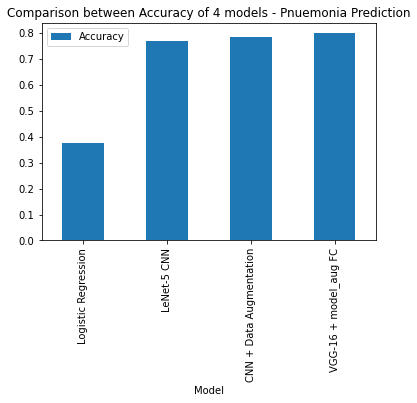

In [46]:
results.set_index(['Model']).plot.bar(title='Comparison between Accuracy of 4 models - Pnuemonia Prediction')

As expected our efforts have given us increased accuracy with the implementation of each model with the use of VGG-16 model with our own Fully Connected layer giving accuracy of 80% on the test dataset for predicting Pnuemonia.